In [13]:
import joblib
import numpy as np
import xarray as xr
import geopandas as gpd
from rasterio import features
from affine import Affine

In [14]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale


def rasterize(
    shapes, coords, latitude="latitude", longitude="longitude", fill=np.nan, **kwargs
):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(
        shapes,
        out_shape=out_shape,
        fill=fill,
        transform=transform,
        dtype=float,
        **kwargs,
    )
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

In [15]:
# use as base data shape for this project
ds = xr.open_dataset('/nobackup/earlacoa/machinelearning/data_annual/predictions/PM2_5_DRY/ds_RES1.0_IND1.0_TRA1.0_AGR1.0_ENE1.0_PM2_5_DRY_popgrid_0.25deg.nc')['PM2_5_DRY']

In [16]:
clips = {}

In [17]:
shapefiles = gpd.read_file("/nobackup/earlacoa/health/data/gadm28_adm0.shp")
countries = [49, 102, 132, 225]

for country in countries:
    shapefile = shapefiles.loc[shapefiles.ID_0 == country]
    shapes = [(shape, n) for n, shape in enumerate(shapefile.geometry)]
    clip = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 
    clips.update({shapefile.NAME_ENGLI.values[0]: clip})

In [18]:
shapefiles = gpd.read_file("/nobackup/earlacoa/health/data/gadm36_CHN_1.shp")
provinces = [province for province in shapefiles.NAME_1]

for province in provinces:
    shapefile = shapefiles.loc[shapefiles.NAME_1 == province]
    shapes = [(shape, n) for n, shape in enumerate(shapefile.geometry)]
    clip = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 
    clips.update({province: clip})

In [19]:
shapefiles = gpd.read_file("/nobackup/earlacoa/health/data/gadm36_CHN_2.shp")
prefecture_ids = [
    "CHN.6.2_1",
    "CHN.6.3_1",
    "CHN.6.4_1",
    "CHN.6.6_1",
    "CHN.6.7_1",
    "CHN.6.15_1",
    "CHN.6.19_1",
    "CHN.6.20_1",
    "CHN.6.21_1",
]

for prefecture_id in prefecture_ids:
    shapefile = shapefiles.loc[shapefiles.GID_2 == prefecture_id]
    shapes = [(shape, n) for n, shape in enumerate(shapefile.geometry)]
    clip = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 
    clips.update({shapefile.NAME_2.values[0]: clip})

In [21]:
clips.keys()

dict_keys(['China', 'Hong Kong', 'Macao', 'Taiwan', 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Nei Mongol', 'Ningxia Hui', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Xinjiang Uygur', 'Xizang', 'Yunnan', 'Zhejiang', 'Dongguan', 'Foshan', 'Guangzhou', 'Huizhou', 'Jiangmen', 'Shenzhen', 'Zhaoqing', 'Zhongshan', 'Zhuhai'])

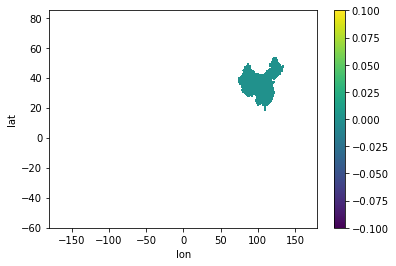

In [22]:
clips['China'].plot()

In [24]:
joblib.dump(clips, f'/nobackup/earlacoa/machinelearning/data_annual/clips.joblib')

['/nobackup/earlacoa/machinelearning/data_annual/clips.joblib']